In [1]:
# Time packages
import cftime, datetime, time
# Numerical analysis packages
import numpy as np, random, scipy, numba
# Local data storage packages
import functools, os, pickle, collections, sys
# Data structure packages
import pandas as pd, xarray as xr, nc_time_axis
xr.set_options(keep_attrs=True)
# Visualization tools
import cartopy, cartopy.crs as ccrs, matplotlib, matplotlib.pyplot as plt
# Local imports
import accessor, composite, composite_snapshots, derived, utilities, socket, visualization, tc_analysis, tc_processing, track_TCs

from multiprocessing import Pool

#### Load IBTrACS data

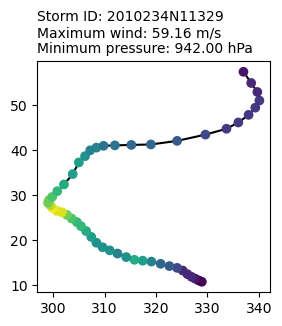

In [2]:
importlib.reload(ibtracs);
basin_name = 'global'
intensity_parameter = 'max_wind'
intensity_range = (30, 60)
IBTrACS_track_data = ibtracs.main(basin_name=basin_name,
                                  intensity_parameter=intensity_parameter,
                                  intensity_range=intensity_range)
random_IBTrACS_TC = ibtracs.pick_random_TC(IBTrACS_track_data)

#### Load and format reanalysis data

In [4]:
# Load data
reanalysis_dirname = '/scratch/gpfs/GEOCLIM/gr7610/tiger3/reference/datasets/ERA5'
reanalysis_filenames = [filename for filename in os.listdir(reanalysis_dirname) if
                        filename.endswith('nc')]
reanalysis_pathnames = [os.path.join(reanalysis_dirname, reanalysis_filename) for reanalysis_filename in reanalysis_filenames]

reanalysis_data = xr.open_mfdataset(reanalysis_pathnames)

# Rename coordinates and data variables to adjust to GFDL QuickTracks outputs
reanalysis_data = reanalysis_data.rename({'valid_time': 'time',
                                          'u10': 'u_ref',
                                          'v10': 'v_ref',
                                          't2m': 't_ref',
                                          'sst': 't_surf',
                                          'sp': 'slp',
                                          'tcwv': 'WVP',})

In [5]:
sample_TC = random_IBTrACS_TC.copy()
dataset_resolution = 0.25 # units of degrees
interval_round = lambda x, y: y * round(x / y) # round coordinates to nearest dataset coordinates

# Select random timestamps from each dataset to ensure they are the same
# Assume all timestamps within a dataset have the same timestamp type
random_storm_timestamp = random.choice(sample_TC.time.values)
random_reanalysis_timestamp = random.choice(reanalysis_data.time.values)

check_timestamp_formats = type(random_storm_timestamp) == type(random_reanalysis_timestamp)
assert check_timestamp_formats, 'Timestamp types between IBTrACS and reanalysis require alignment.'

# Iterate through storm timestamps
storm_timestamps = [storm_timestamp for storm_timestamp in sample_TC.time.values if 
                    storm_timestamp in reanalysis_data.time.values]

# Initialize dictionary for storm track coordinates
storm_track_coordinates = {}
# Construct dictionary for coordinates pertaining to each storm timestamp
for storm_timestamp in storm_timestamps:
    # Obtain longitude and latitude for each timestamp
    storm_track_longitude = sample_TC['center_lon'].loc[sample_TC['time'] == storm_timestamp]
    storm_track_latitude = sample_TC['center_lat'].loc[sample_TC['time'] == storm_timestamp]
    # Round coordinates to align with dataset coordinate system and resolution
    storm_track_coordinates[storm_timestamp] = {'lon': interval_round(storm_track_longitude.item(), dataset_resolution),
                                                'lat': interval_round(storm_track_latitude.item(), dataset_resolution)}

In [6]:
# Coarsening factor
coarsen_factor = 2
interpolation_resolution = dataset_resolution * coarsen_factor
# Define window size
storm_reanalysis_window_size = 12

# Define storm spatial extents for future interpolation
minimum_longitude = np.min([entry['lon'] for entry in storm_track_coordinates.values()])
minimum_latitude = np.min([entry['lat'] for entry in storm_track_coordinates.values()])
maximum_longitude = np.max([entry['lon'] for entry in storm_track_coordinates.values()])
maximum_latitude = np.max([entry['lat'] for entry in storm_track_coordinates.values()])

# Define basis vectors for data interpolation
# Subtract and add window sizes to minima and maxima, respectively, to capture full desired extent
zonal_basis_vector = np.arange(minimum_longitude - storm_reanalysis_window_size, 
                               maximum_longitude + storm_reanalysis_window_size, interpolation_resolution)
meridional_basis_vector = np.arange(minimum_latitude - storm_reanalysis_window_size, 
                                    maximum_latitude + storm_reanalysis_window_size, interpolation_resolution)

In [7]:
def load_timestamp_reanalysis_entry(storm_track_coordinates: dict,
                                    storm_reanalysis_window_size: int | float,
                                    dataset_resolution: float,
                                    reanalysis_data: xr.Dataset,
                                    storm_timestamp):

    storm_reanalysis_container = {}
    storm_reanalysis_window_extent = {}
    
    storm_reanalysis_window_extent[storm_timestamp] = {}
    # Assign zonal window
    storm_reanalysis_window_extent[storm_timestamp][grid_xt] = np.arange(storm_track_coordinates[storm_timestamp]['lon'] - storm_reanalysis_window_size,
                                                                         storm_track_coordinates[storm_timestamp]['lon'] + storm_reanalysis_window_size,
                                                                         dataset_resolution)
    # Assign meridional window
    storm_reanalysis_window_extent[storm_timestamp][grid_yt] = np.arange(storm_track_coordinates[storm_timestamp]['lat'] - storm_reanalysis_window_size,
                                                                         storm_track_coordinates[storm_timestamp]['lat'] + storm_reanalysis_window_size,
                                                                         dataset_resolution)
    # Extract GCM data for the given timestamp and spatial extent
    storm_reanalysis_container[storm_timestamp] = reanalysis_data.sel(time=storm_timestamp)
    storm_reanalysis_container[storm_timestamp] = storm_reanalysis_container[storm_timestamp].sel({grid_xt: storm_reanalysis_window_extent[storm_timestamp][grid_xt]})
    storm_reanalysis_container[storm_timestamp] = storm_reanalysis_container[storm_timestamp].sel({grid_yt: storm_reanalysis_window_extent[storm_timestamp][grid_yt]})

    # Interpolate to different resolution (shoot for 0.5 degrees)
    storm_reanalysis_container[storm_timestamp] = storm_reanalysis_container[storm_timestamp].interp(longitude=zonal_basis_vector).interp(latitude=meridional_basis_vector)
    
    return storm_reanalysis_container[storm_timestamp]

In [8]:
parallel = True
# Define coordinate names:
grid_xt = 'longitude'
grid_yt = 'latitude'
# Initialize a container to hold GCM output connected to each storm timestamp and the corresponding spatial extent
storm_reanalysis_container = {}
# Generate trimming window extents for each timestamp.
# Window extents are defined as: 
# 'grid_xt' = (longitude - window_extent, longitude + window_extent), 
# 'grid_yt' = (latitude - window_extent, latitude + window_extent)

from multiprocessing import Pool
import functools

# Define partial function to streamline function calls, since the only variabl argument is `storm_timestamps`
partial_load_timestamp_reanalysis_entry = functools.partial(load_timestamp_reanalysis_entry,
                                                             storm_track_coordinates,
                                                             storm_reanalysis_window_size,
                                                             dataset_resolution,
                                                             reanalysis_data)

start_time = time.time()

# Parallel implementation
if parallel:
    # Distribute data loading in parallel over each timestamp
    with Pool() as pool:
        storm_reanalysis_timestamp_entry = pool.map(partial_load_timestamp_reanalysis_entry, storm_timestamps)
        storm_reanalysis_data = xr.concat(storm_reanalysis_timestamp_entry, dim='time').sortby('time')
        pool.close()
# Serial implementation
else:
    # Initialize container dictionary
    storm_reanalysis_container = {}
    # Iterate over all timestamps to find reanalysis data for the given entry
    for storm_timestamp in storm_timestamps:
        storm_reanalysis_container[storm_timestamp] = partial_load_timestamp_reanalysis_entry(storm_timestamp)
    # Concatenate all GCM output data corresponding to storm into a single xArray Dataset
    storm_reanalysis_data = xr.concat(storm_reanalysis_container.values(), dim='time').sortby('time')

print(f'Elapsed time to load reanalysis storm: {(time.time() - start_time):.2f} s.')

Elapsed time to load reanalysis storm: 3.10 s.


In [9]:
''' Append information from `track data` to netCDF object containing GCM output. '''

storm_reanalysis_data = TC_tracker.join_track_GCM_data(storm_track_data=sample_TC,
                                                       storm_gcm_data=storm_reanalysis_data,
                                                       storm_time_variable='time')

In [10]:
TC_tracker.save_storm_netcdf(storm_reanalysis_data,
                             'ERA5',
                             'reanalysis')

[save_storm_netcdf] Loading data for TC.model-ERA5.experiment-reanalysis.storm_ID-2010234N11329.max_wind-59.min_slp-942.basin-NA.nc
Elapsed loading time for TC.model-ERA5.experiment-reanalysis.storm_ID-2010234N11329.max_wind-59.min_slp-942.basin-NA.nc: 17.15 s
File size for TC.model-ERA5.experiment-reanalysis.storm_ID-2010234N11329.max_wind-59.min_slp-942.basin-NA.nc: 120.51 MB



Text(0.0, 1.0, 'Storm ID: 2010234N11329\nMaximum wind: 33.44 m/s\nMinimum pressure: 987.00 hPa')

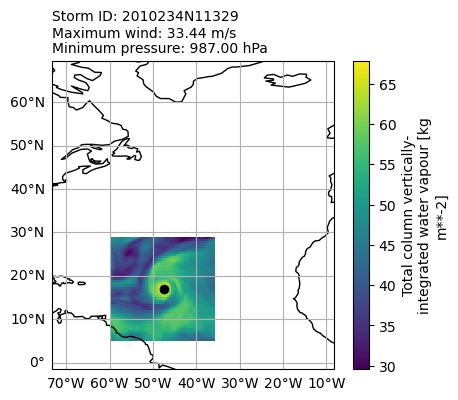

In [12]:
fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

field_name = 'WVP'
time_index = 13
storm_reanalysis_data_sample = storm_reanalysis_data.isel(time=time_index)
storm_reanalysis_data_sample[field_name].plot(ax=ax, transform=ccrs.PlateCarree())
ax.scatter(storm_reanalysis_data_sample['center_lon'], storm_reanalysis_data_sample['center_lat'], 
           c=storm_reanalysis_data_sample['max_wind'], cmap='magma', transform=ccrs.PlateCarree())


ax.gridlines(draw_labels=['bottom', 'left'])
ax.coastlines()

maximum_wind = storm_reanalysis_data_sample['max_wind']
minimum_pressure = storm_reanalysis_data_sample['min_slp']
ax.set_title('') # xArray bug - this blanks out the title
ax.set_title(f'Storm ID: {storm_reanalysis_data_sample.attrs['storm_id']}\nMaximum wind: {maximum_wind:.2f} m/s\nMinimum pressure: {minimum_pressure:.2f} hPa', loc='left', ha='left', fontsize=10)